In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import sys
sys.path.append('../')
from src import AFDB_tools, treescore , foldseek2tree
import pandas as pd
import torch

In [34]:
#load cath dataset from CATH data folder with comment lines as # and white space seperator
domain_df = pd.read_csv('../CATH_data/cath-domain-list.txt' , comment='#' , header = None , delim_whitespace=True)
print(domain_df.head())

        0   1   2   3   4   5   6   7   8   9   10     11
0  1oaiA00   1  10   8  10   1   1   1   1   1  59    1.0
1  1go5A00   1  10   8  10   1   1   1   1   2  69  999.0
2  3frhA01   1  10   8  10   2   1   1   1   1  58    1.2
3  3friA01   1  10   8  10   2   1   1   1   2  54    1.8
4  3b89A01   1  10   8  10   2   1   1   2   1  54    2.6


In [35]:
#change the type to string
domain_df = domain_df.astype(str)
domain_df['superfam'] = domain_df[[1,2,3,4]].apply(lambda x : '.'.join(x), axis = 1) 


In [36]:
siftsdf = pd.read_csv('../CATH_data/pdb_chain_cath_uniprot.csv', header=1 )


In [37]:
#merge with domain df on cath id
siftsdf = siftsdf.merge(domain_df, left_on = 'CATH_ID' , right_on = 0 , how = 'left')
siftsdf = siftsdf.dropna()
print(siftsdf.head(), len(siftsdf) , print(len(siftsdf.superfam.unique())))

6485
    PDB CHAIN SP_PRIMARY  CATH_ID        0  1   2    3   4  5  6  7   8  9  \
0  101m     A     P02185  101mA00  101mA00  1  10  490  10  1  1  1  51  4   
1  102l     A     P00720  102lA00  102lA00  1  10  530  40  1  1  2  30  2   
2  102m     A     P02185  102mA00  102mA00  1  10  490  10  1  1  1  42  7   
3  103l     A     P00720  103lA00  103lA00  1  10  530  40  1  1  2  69  2   
4  103m     A     P02185  103mA00  103mA00  1  10  490  10  1  1  1  42  8   

    10    11     superfam  
0  154  2.07  1.10.490.10  
1  163  1.74  1.10.530.40  
2  154  1.84  1.10.490.10  
3  159   1.9  1.10.530.40  
4  154  2.07  1.10.490.10   451320 None


['1.10.490.10' '1.10.530.40' '3.40.30.10' ... '6.10.140.1500'
 '1.20.120.1500' '1.10.10.1760'] 6485


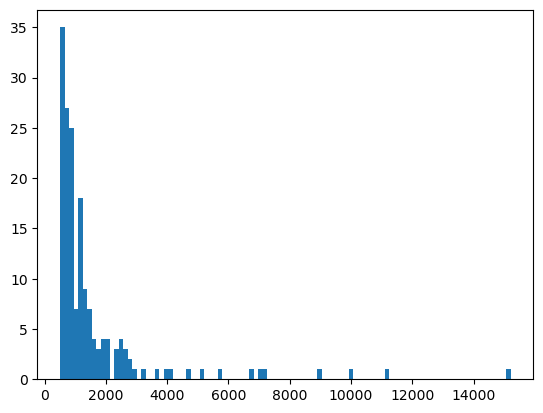

In [38]:
from matplotlib import pyplot as plt
print(siftsdf.superfam.unique(),len(siftsdf.superfam.unique()))
#make a histogram of the superfam counts
famsizes = siftsdf.superfam.value_counts().to_numpy()


plt.hist( famsizes[famsizes>10] , bins = 100)
plt.show()

done 702


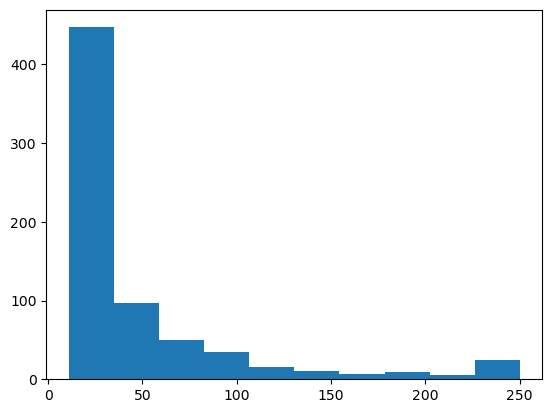

In [42]:
from src import AFDB_tools
import os
datapath = '../CATH_data/'
nprots = 250
minprots = 500
fams = 2000
total = 0
lengths = []
#iterate over all superfamilies and create a tree for each

if not os.path.exists(datapath):
    os.mkdir(datapath)
for i,superfam in enumerate(siftsdf.superfam.unique()):
    if not os.path.exists(datapath+superfam):
        os.mkdir(datapath+superfam)

    #create a tree for each superfam
    #sample 1000 proteins from the superfam
    sub = siftsdf[siftsdf.superfam == superfam]
    prots = list(sub['SP_PRIMARY'].unique())
    prots = prots[:nprots]
    #output the sequence dataset to a file
    #create a folder for the superfam if it does not exist
    #output the uniport ids to a file
    if len(prots)> 10:
        lengths.append(len(prots))

        total+=1
        with open(datapath+superfam+'/identifiers.txt', 'w') as f:
            f.write('\n'.join( prots ))
print('done', total)
plt.hist(lengths)
plt.show()